In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

逻辑回归在spark中的实现简介
=======================

分析用的代码版本信息：

```bash
~/W/g/spark ❯❯❯ git log -n 1
commit d9ad78908f6189719cec69d34557f1a750d2e6af
Author: Wenchen Fan <wenchen@databricks.com>
Date:   Fri May 26 15:01:28 2017 +0800

    [SPARK-20868][CORE] UnsafeShuffleWriter should verify the position after FileChannel.transferTo
```

### 0. 总纲

下图是ml包中逻辑回归的构成情况：

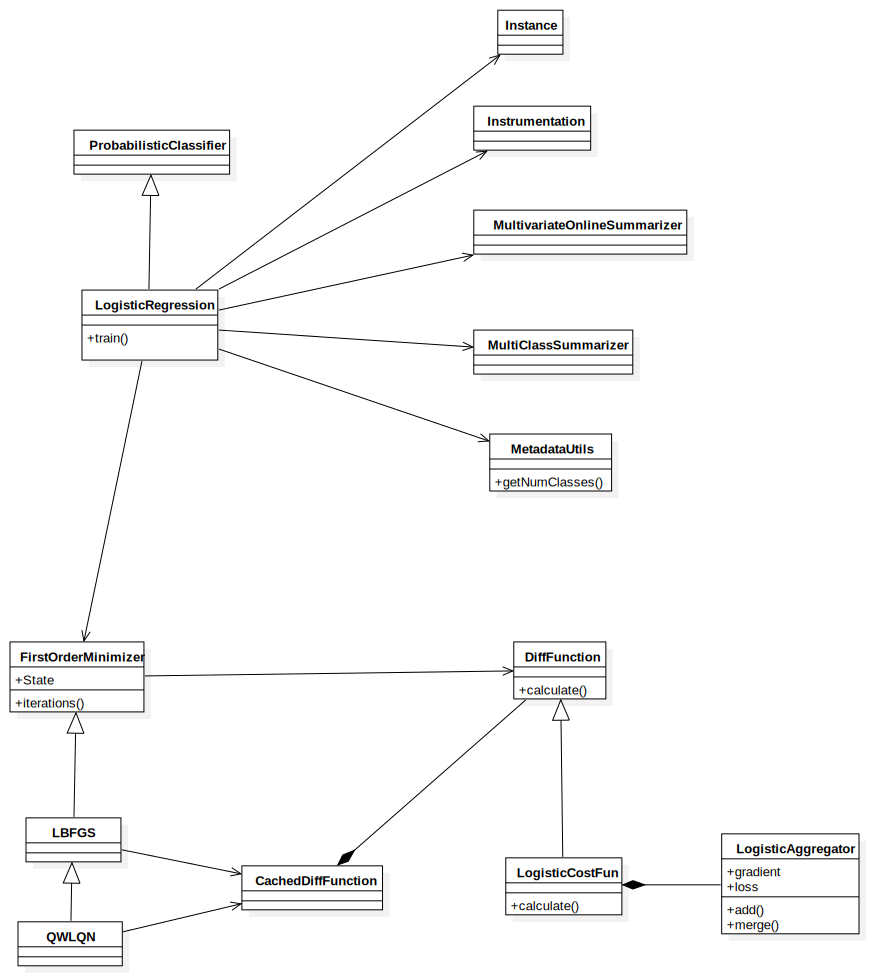

In [2]:
SVG("./res/spark_ml_lr.svg")

可以看到，逻辑回归是比较简单的，在它的`train`函数里，除开左侧的几个辅助类：

+ Instance: 封装数据
+ MetadataUtils: 数据信息
+ Instrumentation: 日志 
+ Multi*Summarizer: 统计

主要就是做两件事：

+ 构造损失函数 => costFun: DiffFunction
+ 创建寻优算子 => optimizer: FirstOrderMinizer    
  ml里两种算子都是拟牛顿法，理论上比SGD迭代更少，收敛更快。其中QWLQN是LBFGS的变种，可使用L1正则。
  
接下来，我们就将精力放在这两件事的实现上。这里寻优算子主要是根据正则确定的，而损失函数会由二分类和多分类而有所变化，下面一一叙迖述。

### 1. 寻优算子

jupyter的markdown，无法正确处理`$`取值语法，所以做了点小变动。

```scala
 645         val optimizer = if (elasticNetParam == 0.0 || regParam == 0.0) {
 646 // +--  4 lines: if (lowerBounds != null && upperBounds != null) {--------------------------------------
 650             new BreezeLBFGS[BDV[Double]](maxIter, 10, tol)
 651           }
 652         } else {
 653           val standardizationParam = standardization
 654           def regParamL1Fun = (index: Int) => {
 655 // +--  2 lines: Remove the L1 penalization on the intercept--------------------------------------------
 657             if (isIntercept) {
 658               0.0
 659             } else {
 660               if (standardizationParam) {
 661                 regParamL1
 662               } else {
 663                 val featureIndex = index / numCoefficientSets
 664 // +--  5 lines: If `standardization` is false, we still standardize the data---------------------------
 669                 if (featuresStd(featureIndex) != 0.0) {
 670                   regParamL1 / featuresStd(featureIndex)
 671                 } else {
 672                   0.0
 673                 }
 674               }
 675             }
 676           }
 677           new BreezeOWLQN[Int, BDV[Double]](maxIter, 10, regParamL1Fun, $(tol))
 678         }
```

可以看到，逻辑很简单：如果不用正则，或只用L2，就用LBFGS算子；如果用到L1正则，就用QWLQN算子。其中下半代码均是在折算合适的L1正则值。

因为QWLQN会自己处理L1正则，所以在接下来的损失函数计算中，我们只考虑L2正则，而不管L1。

### 2. 损失函数
#### 2.1 二分类

预测公式：$f(x) = \frac1{1 + e^{w^T x}}$

[损失函数](http://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression)定义是：

\begin{equation}
L(w;x,y) = \log(1+e^{-y w^T x}) + r_2 \cdot \frac{1}{2} w^T w + r_1 \cdot \|w\|
\end{equation}

[导数是](http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions)：

\begin{align}
  \frac{\partial L}{\partial w} &= -y \left(1-\frac1{1+e^{-y w^T x}} \right) \cdot x + r_2 w \pm r_1 \\
  &= \left ( \frac{y}{1+e^{-y w^T x}} - y \right ) \cdot x + r_2 w \pm r_1 \\
  \text{因为$y$只有1和-1两值，可简化为} \\
  &= \left ( \frac{1}{1+e^{-w^T x}} - y \right ) \cdot x + r_2 w \pm r_1 \\
  &= \left ( f(x) - y \right ) \cdot x + r_2 w \pm r_1
\end{align}

好，我们先看没有正则的计算，在LogisticAggregator类里：

```scala
1670   /** Update gradient and loss using binary loss function. */
1671   private def binaryUpdateInPlace(
1672       features: Vector,
1673       weight: Double,
1674       label: Double): Unit = {
1675 +--  4 lines: val localFeaturesStd = bcFeaturesStd.value----------
1679     val margin = - {
1680       var sum = 0.0
1681       features.foreachActive { (index, value) =>
1682         if (localFeaturesStd(index) != 0.0 && value != 0.0) {
1683           sum += localCoefficients(index) * value / localFeaturesStd(index)
1684         }
1685       }
1686       if (fitIntercept) sum += localCoefficients(numFeaturesPlusIntercept - 1)
1687       sum
1688     }
1689
1690     val multiplier = weight * (1.0 / (1.0 + math.exp(margin)) - label)
1691
1692     features.foreachActive { (index, value) =>
1693       if (localFeaturesStd(index) != 0.0 && value != 0.0) {
1694         localGradientArray(index) += multiplier * value / localFeaturesStd(index)
1695       }
1696     }
1697
1698     if (fitIntercept) {
1699       localGradientArray(numFeaturesPlusIntercept - 1) += multiplier
1700     }
1701
1702     if (label > 0) {
1703       // The following is equivalent to log(1 + exp(margin)) but more numerically stable.
1704       lossSum += weight * MLUtils.log1pExp(margin)
1705     } else {
1706       lossSum += weight * (MLUtils.log1pExp(margin) - margin)
1707     }
1708   }
```

其中，
+ margin = $-w^T x$    
  注意：这里用的$x / \operatorname{std}(x)$，相当于归一化，统一量纲。很奇怪，没有同时移动坐标，我不清楚是否合理。
+ multiplier = $\frac1{1 + e^{w^T x}} - y$ = $f(x) - y$
+ localGradientArray = $(f(x) - y) x$
+ lossSum = $\log(1+e^{-y w^T x})$。注意：因为margin计算时是$y=1$，所以1706L，对$y=-1$做了变换。数学技巧比较简单：

\begin{align}
  log(1 + e^x) - x &= log(1 + e^x) - log(e^x) \\
  &= log(\frac{1 + e^x}{e^x}) \\
  &= log(1 + e^{-x})
\end{align}

再在损失函数和偏导里，均加上L2的部份，代码在LogisticCostFun类的calculate方法里：

```scala
1877   override def calculate(coefficients: BDV[Double]): (Double, BDV[Double]) = {
1878 // +--  6 lines: val coeffs = Vectors.fromBreeze(coefficients)------
1884
1885     val logisticAggregator = {
1886 // +--  3 lines: val seqOp = (c: LogisticAggregator, instance: Instance) =>
1889       instances.treeAggregate(
1890         new LogisticAggregator(bcCoeffs, bcFeaturesStd, numClasses, fitIntercept,
1891           multinomial)
1892       )(seqOp, combOp, aggregationDepth)
1893     }
1894
1895     val totalGradientMatrix = logisticAggregator.gradient
1896     val coefMatrix = new DenseMatrix(numCoefficientSets, numFeaturesPlusIntercept, coeffs.toArray)
1897     // regVal is the sum of coefficients squares excluding intercept for L2 regularization.
1898     val regVal = if (regParamL2 == 0.0) {
1899       0.0
1900     } else {
1901       var sum = 0.0
1902       coefMatrix.foreachActive { case (classIndex, featureIndex, value) =>
1903         // We do not apply regularization to the intercepts
1904         val isIntercept = fitIntercept && (featureIndex == numFeatures)
1905         if (!isIntercept) {
1906 // +--  2 lines: The following code will compute the loss of the regularization; also---
1908           sum += {
1909             if (standardization) {
1910               val gradValue = totalGradientMatrix(classIndex, featureIndex)
1911               totalGradientMatrix.update(classIndex, featureIndex, gradValue + regParamL2 * value)
1912               value * value
1913 // +-- 14 lines: } else {------------------
1927             }
1928           }
1929         }
1930       }
1931       0.5 * regParamL2 * sum
1932     }
1933 // +--  2 lines: bcCoeffs.destroy(blocking = false)--------
1935     (logisticAggregator.loss + regVal, new BDV(totalGradientMatrix.toArray))
1936   }
1
```

其中，1912L和1931L是加L2正则$r_2 \cdot \frac{1}{2}w^T w$；1911L是加L2的偏导$r_2 \cdot w$。因为有额外的分支处理归一的情况，分支较多。同时，损失和偏导混在一起算，代码有点混杂。

如此，就有了二分类的损失函数和偏导数。

```scala
 601         val costFun = new LogisticCostFun(instances, numClasses, fitIntercept,
 602           standardization, bcFeaturesStd, regParamL2, multinomial = isMultinomial,
 603           aggregationDepth)
```

#### 2.2 多分类